In [51]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from globalVars import DATASET_DIRECTORY, IMAGE_SIZE, BATCH_SIZE, TRAINING_SIZE, SEED, SHUFFLE_SIZE, FILTERS_NUMBER, FILTER_SIZE, INPUT_SHAPE, POOLING_SIZE, EPOCHS

In [3]:
from helpers import split_data_set, predict

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIRECTORY,
    shuffle =True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
n_classes = len(class_names)
n_classes

3

In [7]:
len(dataset) # Number of batches

68

In [8]:
for image_batch, labels_batch in dataset.take(5): # The images inside tha batch (32) and the label (0 or 1 or 2) from the batches from first batch to batch no.5
    print(image_batch.shape)
    print(f"{labels_batch.numpy()}")

(32, 256, 256, 3)
[0 1 0 0 1 0 2 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 2 0 1 1 0 0 0 0 0 0]
(32, 256, 256, 3)
[0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 0 2 0 2 0 0 0 0 1 0 1]
(32, 256, 256, 3)
[1 0 2 1 1 1 1 1 1 0 1 2 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 2 1 1 1 0]
(32, 256, 256, 3)
[1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 2 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1]
(32, 256, 256, 3)
[1 1 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 0 0 0 1]


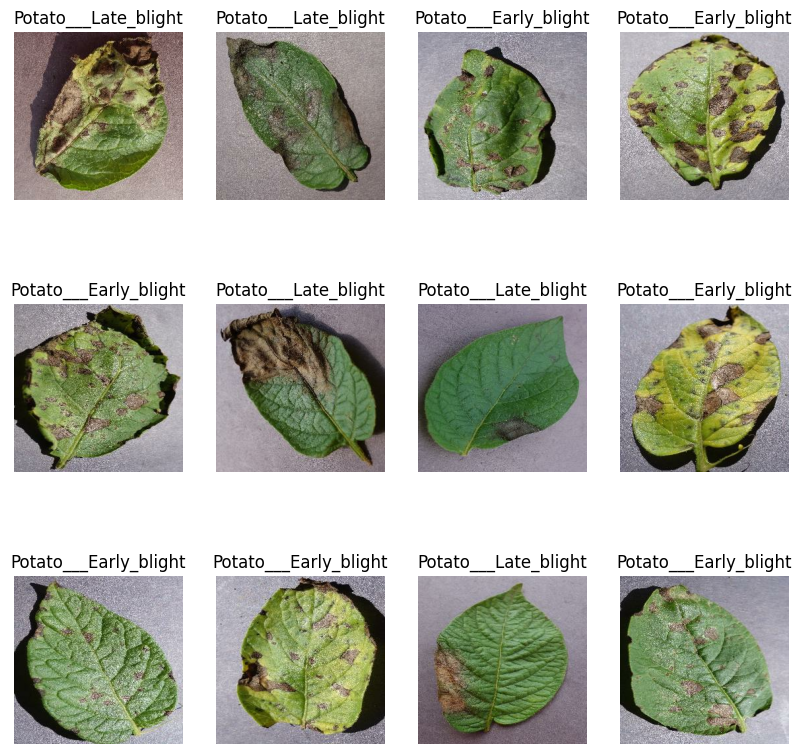

In [9]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1) # number of rows, number of columns, the position of the image
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

<h1>Split data</h1>
<h4 style="margin-bottom: 8px;">we will split the dataset to:</h4>
<p style="margin: 0;">80% ==> training</p>
<p style="margin: 0;">20% ==> 10% validation, 10% test</p>

In [19]:
training_ds, validation_ds, testing_ds = split_data_set(dataset, TRAINING_SIZE, 0.1, True, SHUFFLE_SIZE, SEED)

In [20]:
len(training_ds)

54

In [21]:
len(validation_ds)

6

In [22]:
len(testing_ds)

8

In [23]:
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testing_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<h1>Pre-processing</h1>

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # change the dimensions to IMAGE_SIZE * IMAGE_SIZE
    layers.Rescaling(1.0/255) # change the value of the pixel color to be between [0, 1]
])

<h1>Data Augmentation</h1>

In [25]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomRotation(0.2) 
])

<h1>Model</h1>

In [26]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(FILTERS_NUMBER, FILTER_SIZE, activation="relu", input_shape = INPUT_SHAPE),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Conv2D(FILTERS_NUMBER * 2, FILTER_SIZE, activation="relu"),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Conv2D(FILTERS_NUMBER * 2, FILTER_SIZE, activation="relu"),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Conv2D(FILTERS_NUMBER * 2, FILTER_SIZE, activation="relu"),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Conv2D(FILTERS_NUMBER * 2, FILTER_SIZE, activation="relu"),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Conv2D(FILTERS_NUMBER * 2, FILTER_SIZE, activation="relu"),
    layers.MaxPooling2D(POOLING_SIZE),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])

model.build(input_shape=INPUT_SHAPE)

In [27]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_3 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_4 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

<h1>Training</h1>

In [33]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [34]:
history = model.fit(
    training_ds,
    epochs=EPOCHS,
    verbose=1, # Appear training details (accuracy, loss)
    validation_data=validation_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 573ms/step - accuracy: 0.4680 - loss: 0.9468 - val_accuracy: 0.4375 - val_loss: 0.8712
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 577ms/step - accuracy: 0.5690 - loss: 0.7942 - val_accuracy: 0.7604 - val_loss: 0.6771
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 625ms/step - accuracy: 0.7385 - loss: 0.5941 - val_accuracy: 0.8542 - val_loss: 0.2783
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 696ms/step - accuracy: 0.8437 - loss: 0.3509 - val_accuracy: 0.8854 - val_loss: 0.2883
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 709ms/step - accuracy: 0.8843 - loss: 0.2790 - val_accuracy: 0.8750 - val_loss: 0.3170
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 715ms/step - accuracy: 0.8921 - loss: 0.2703 - val_accuracy: 0.8958 - val_loss: 0.2089
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 628ms/step - accuracy: 0.9282 - loss: 0.1889 - val_accuracy: 0.9740 - val_loss: 0.0742
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 614ms/step - accuracy: 0.9350 - loss: 0.1667 - val_accu

<h1>Testing</h1>

In [35]:
scores = model.evaluate(testing_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9611 - loss: 0.0899


<h1>Showing Results</h1>

In [36]:
scores # [lose, accuracy]

[0.07598122954368591, 0.96875]

In [37]:
history

In [38]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [39]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [40]:
len(history.history["accuracy"])

50

In [41]:
acc = history.history["accuracy"] # training accuracy
acc

[0.47124412655830383,
 0.6156103014945984,
 0.7863849997520447,
 0.841549277305603,
 0.8914319276809692,
 0.9014084339141846,
 0.9307511448860168,
 0.9237089157104492,
 0.9430751204490662,
 0.9143192768096924,
 0.9571596384048462,
 0.9706572890281677,
 0.9647887349128723,
 0.9683098793029785,
 0.9530516266822815,
 0.9583333134651184,
 0.9454225301742554,
 0.9618544578552246,
 0.9853286147117615,
 0.9806337952613831,
 0.9806337952613831,
 0.9724178314208984,
 0.9841549396514893,
 0.9794601202011108,
 0.9771126508712769,
 0.9788732528686523,
 0.9818075299263,
 0.9882628917694092,
 0.9806337952613831,
 0.9923709034919739,
 0.9900234937667847,
 0.9888497591018677,
 0.9865023493766785,
 0.9829812049865723,
 0.9800469279289246,
 0.9806337952613831,
 0.9911971688270569,
 0.9888497591018677,
 0.9935445785522461,
 0.9671361446380615,
 0.9765258431434631,
 0.98591548204422,
 0.9941314458847046,
 0.9923709034919739,
 0.9906103014945984,
 0.9958920478820801,
 0.9941314458847046,
 0.993544578552246

In [42]:
val_acc = history.history["val_accuracy"] # validation accuracy
val_acc

[0.4375,
 0.7604166865348816,
 0.8541666865348816,
 0.8854166865348816,
 0.875,
 0.8958333134651184,
 0.9739583134651184,
 0.953125,
 0.9322916865348816,
 0.9010416865348816,
 0.9635416865348816,
 0.96875,
 0.8958333134651184,
 0.9635416865348816,
 0.984375,
 0.953125,
 0.953125,
 0.9739583134651184,
 0.9895833134651184,
 0.9739583134651184,
 0.9739583134651184,
 0.9479166865348816,
 0.921875,
 0.984375,
 0.984375,
 0.9739583134651184,
 0.9895833134651184,
 0.984375,
 0.9635416865348816,
 0.9739583134651184,
 0.9583333134651184,
 0.9635416865348816,
 0.9791666865348816,
 0.9739583134651184,
 0.96875,
 0.9791666865348816,
 0.9322916865348816,
 0.984375,
 0.984375,
 0.96875,
 0.859375,
 0.9739583134651184,
 0.9947916865348816,
 0.9791666865348816,
 0.9947916865348816,
 0.96875,
 0.9895833134651184,
 1.0,
 0.9895833134651184,
 0.9791666865348816]

In [43]:
loss = history.history["loss"]
loss

[0.9014003276824951,
 0.7591090798377991,
 0.4940439462661743,
 0.3765519857406616,
 0.27202221751213074,
 0.24888548254966736,
 0.17672231793403625,
 0.20414362847805023,
 0.1545865833759308,
 0.20847202837467194,
 0.11333360522985458,
 0.08006815612316132,
 0.09453068673610687,
 0.0828828439116478,
 0.12107609212398529,
 0.10502918064594269,
 0.12849411368370056,
 0.09159352630376816,
 0.04137840494513512,
 0.05145704746246338,
 0.05301533639431,
 0.06436216831207275,
 0.04456043243408203,
 0.06018238514661789,
 0.05502721667289734,
 0.05745816230773926,
 0.05689243972301483,
 0.03556659072637558,
 0.05108879879117012,
 0.02479654550552368,
 0.02621685341000557,
 0.031213779002428055,
 0.0401606522500515,
 0.04990147426724434,
 0.04626765102148056,
 0.044738464057445526,
 0.02533971704542637,
 0.035708121955394745,
 0.01604495197534561,
 0.08894861489534378,
 0.07386218756437302,
 0.041874196380376816,
 0.016958586871623993,
 0.02091359719634056,
 0.03365296497941017,
 0.017130717635

In [44]:
val_loss = history.history["val_loss"]
val_loss

[0.8711727261543274,
 0.6771100163459778,
 0.2782596945762634,
 0.2883208692073822,
 0.31695276498794556,
 0.20892967283725739,
 0.07420563697814941,
 0.11023175716400146,
 0.1692103147506714,
 0.2315460443496704,
 0.08847552537918091,
 0.0651215985417366,
 0.2336016297340393,
 0.09817760437726974,
 0.05765877291560173,
 0.10202574729919434,
 0.11620064824819565,
 0.06913750618696213,
 0.021084243431687355,
 0.06580246984958649,
 0.07641033083200455,
 0.08986388891935349,
 0.18943601846694946,
 0.026191426441073418,
 0.04503465071320534,
 0.0779738798737526,
 0.03497229143977165,
 0.05831669643521309,
 0.07140810042619705,
 0.07771048694849014,
 0.07412651181221008,
 0.11064126342535019,
 0.05046079680323601,
 0.05952240899205208,
 0.09689825028181076,
 0.05729581415653229,
 0.15187473595142365,
 0.03653007745742798,
 0.029504969716072083,
 0.13197755813598633,
 0.3007519543170929,
 0.042108941823244095,
 0.02665329910814762,
 0.06181485578417778,
 0.014254583977162838,
 0.080378092825

Text(0.5, 1.0, 'Training and Validation Loss')

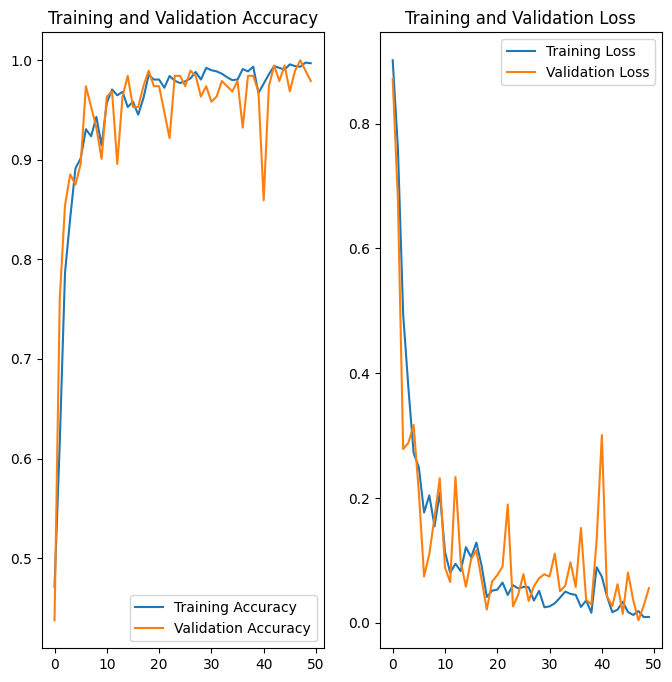

In [45]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

First image to predict
Actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
[2.39862875e-05 9.99976039e-01 1.28643585e-08]
Predicted label: Potato___Late_blight


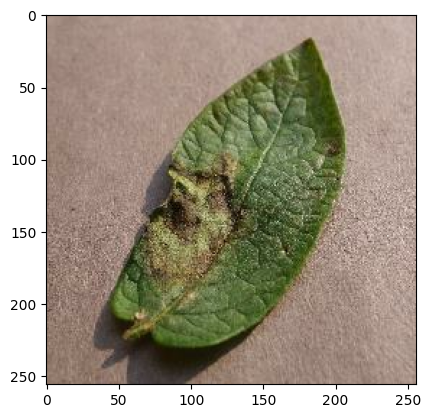

In [46]:
for images_batch, labels_batch in testing_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


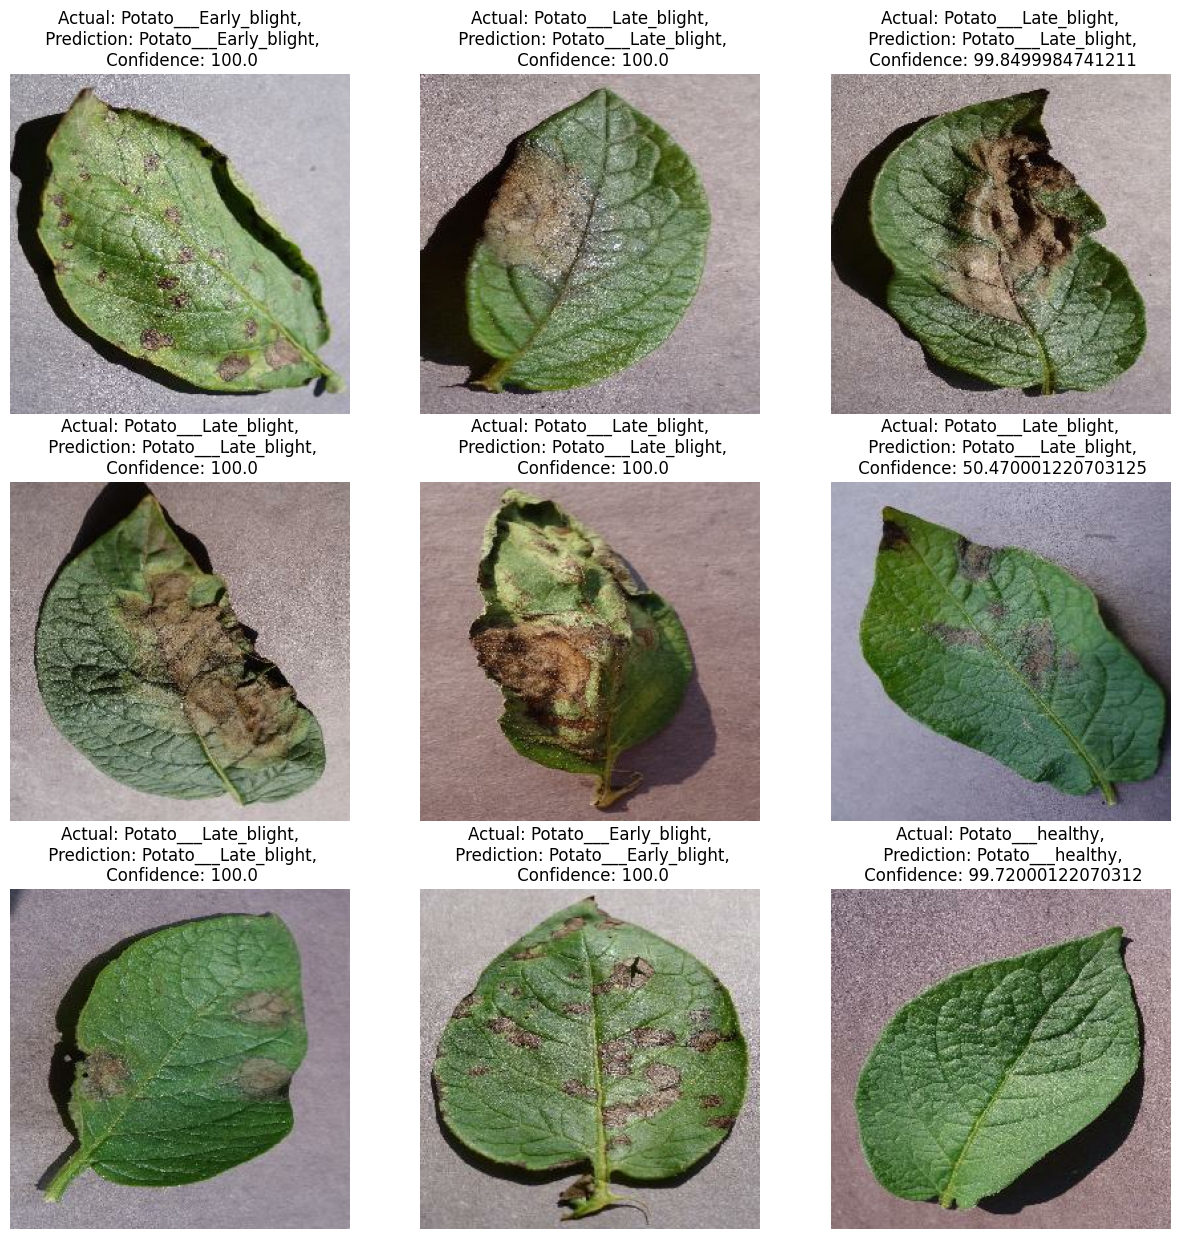

In [50]:
plt.figure(figsize=(15, 15))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy(), class_names)
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Prediction: {predicted_class},\n Confidence: {confidence}")
        plt.axis("off")

<h1>Saving Model</h1>

In [59]:
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.export(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


Saved artifact at '../models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2476628321552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476628318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476628314448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476628314832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476628317328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549201680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549200912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549202448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549200336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549203216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2476549202640: TensorSpec(shape=(), 